In [ ]:
# TIME TO BUILD MLP - Paper

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [12]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [13]:
len(words)

32033

In [20]:
# Create a dictionary that maps letters to integers and vice versa
chars = sorted(list(set(''.join(words))))
stoi = {ch : i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i : ch for ch, i in stoi.items()}

In [79]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for word in words:
    # print(word)
    context = [0] * block_size
    for ch in word + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [24]:
X.shape, X.dtype, Y.shape, Y.dtype
X
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [103]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8) # 80% of the words
n2 = int(len(words) * 0.9) # 90% of the words

Xtr, Ytr = build_dataset(words[:n1]) # training set -> upto n1
Xdev, Ydev = build_dataset(words[n1:n2]) # development set -> (n2 - n1)
Xte, Yte = build_dataset(words[n2:]) # test set -> (n - n2)

torch.Size([182580, 3]) torch.int64 torch.Size([182580]) torch.int64
torch.Size([22767, 3]) torch.int64 torch.Size([22767]) torch.int64
torch.Size([22799, 3]) torch.int64 torch.Size([22799]) torch.int64


In [30]:
# lets us build the embedding table C
C = torch.randn((27, 2)) # 27 characters, 2 dimensions - each character is represented by a vector of size 2
C
print(C[5])

onehot = F.one_hot(torch.tensor(5), num_classes=27).float() # one hot encoding of the 5th character
onehot @ C

C[[5, 6, 7]] # embedding of the 5th, 6th and 7th character

tensor([ 0.6198, -2.3652])


tensor([[ 0.6198, -2.3652],
        [-0.0595, -0.6902],
        [ 0.0917,  0.0919]])

In [ ]:
# the way to think here is that the input X can be made one hot, which is then send to first neural network layer,
# in this layer the W are kind of represented by C, no non linearlity is needed here.

In [33]:
emb = C[X] # embedding of the input X
emb.shape

torch.Size([32, 3, 2])

In [ ]:
# no. of inputs that go the next layer is 3 * 2 = 6, where 3 is the context length and 2 is the embedding size

In [34]:
W1 = torch.randn((6, 100)) # 6 weights because no. of inputs coming to each neuron is 6, 100 neurons
b1 = torch.randn((100)) # 100 biases

In [35]:
emb @ W1 + b1 # output of the first layer
# RuntimeError: mat1 and mat2 shapes cannot be multiplied

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [42]:
# to fix this we need to flatten the input, we will be using torch cat for this
emb[:, 0, :].shape

torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape # flattened input for 0, 1, 2 context length

#  above the problem is we will have to keep changing it for context length, instead lets use bind
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

In [46]:
# visiting some internals of tensor - ezyang.com
a = torch.arange(18)
a.storage() # storage is a contiguous array of memory
a.view(3, 6)

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]])

In [47]:
# if we use view on the embeddings we dont need to concatenate and bind
emb.view(32, 6)

tensor([[ 0.4054,  0.5231,  0.4054,  0.5231,  0.4054,  0.5231],
        [ 0.4054,  0.5231,  0.4054,  0.5231,  0.6198, -2.3652],
        [ 0.4054,  0.5231,  0.6198, -2.3652,  1.2566,  0.9025],
        [ 0.6198, -2.3652,  1.2566,  0.9025,  1.2566,  0.9025],
        [ 1.2566,  0.9025,  1.2566,  0.9025,  1.2383, -1.0258],
        [ 0.4054,  0.5231,  0.4054,  0.5231,  0.4054,  0.5231],
        [ 0.4054,  0.5231,  0.4054,  0.5231,  0.6727, -0.1687],
        [ 0.4054,  0.5231,  0.6727, -0.1687,  0.3961, -0.6870],
        [ 0.6727, -0.1687,  0.3961, -0.6870, -0.8470,  0.0491],
        [ 0.3961, -0.6870, -0.8470,  0.0491,  1.0220, -0.2910],
        [-0.8470,  0.0491,  1.0220, -0.2910, -0.8470,  0.0491],
        [ 1.0220, -0.2910, -0.8470,  0.0491,  1.2383, -1.0258],
        [ 0.4054,  0.5231,  0.4054,  0.5231,  0.4054,  0.5231],
        [ 0.4054,  0.5231,  0.4054,  0.5231,  1.2383, -1.0258],
        [ 0.4054,  0.5231,  1.2383, -1.0258,  1.0220, -0.2910],
        [ 1.2383, -1.0258,  1.0220, -0.2

In [53]:
# h = emb.view(32, 6) @ W1 + b1 # output of the first layer
# h = emb.view(emb.shape[0], 6) @ W1 + b1 # output of the first layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # output of the first layer, broadcasting is happening here, 32, 100 and 1, 100
h.shape

# this is giving us 32 examples, 100 neurons each

torch.Size([32, 100])

In [55]:
# lets create the second layer
W2 = torch.randn((100, 27)) # 100 neurons, 27 classes
b2 = torch.randn((27)) # 27 biases

In [56]:
logits = h @ W2 + b2 # output of the second layer
logits.shape

torch.Size([32, 27])

In [57]:
# lets do softmax
counts = torch.exp(logits)
prob = counts / counts.sum(dim=1, keepdim=True)

In [58]:
prob.shape

torch.Size([32, 27])

In [61]:
# lets start plucking out the probabilities for the correct classes
# torch.arange(32)
prob[torch.arange(32), Y]

tensor([1.6315e-04, 5.3087e-10, 1.6051e-03, 3.8081e-09, 2.1226e-03, 3.5438e-05,
        4.4443e-08, 1.7366e-05, 5.7399e-04, 5.0090e-06, 1.9840e-09, 1.3518e-03,
        4.4281e-15, 1.9657e-03, 9.7114e-10, 1.0468e-06, 1.7066e-13, 1.4827e-03,
        4.1694e-12, 5.6969e-06, 1.3101e-05, 7.9173e-10, 2.2141e-01, 4.5709e-03,
        2.1836e-06, 3.4018e-04, 3.2049e-08, 6.1464e-08, 4.6455e-10, 1.2485e-08,
        8.9204e-11, 6.5668e-04])

In [59]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [64]:
# based on the above we can calculate the loss
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.3323)

Simplification of Multiplication into Addition: Likelihood functions often involve the product of probabilities. When dealing with small probabilities, these products can become very small, leading to computational difficulties. Taking the logarithm of these probabilities converts the products into sums, which are easier to handle both computationally and analytically.

Numerical Stability: The logarithm function transforms very small numbers into larger, more manageable numbers. This helps in avoiding issues with numerical underflow, a common problem when computing products of many probabilities in computers.

In [65]:
# ----------------------------- lets do it all in good way -----------------------------

In [177]:
Xtr.shape, Ytr.shape # X is the input, Y is the target

(torch.Size([182580, 3]), torch.Size([182580]))

In [178]:
g = torch.Generator().manual_seed(2147483647) # random seed
#C = torch.randn((27, 2), generator=g) # embedding table
#W1 = torch.randn((6, 300), generator=g) # first layer weights
C = torch.randn((27, 10), generator=g) # embedding table, increased the embedding size to 10
W1 = torch.randn((30, 200), generator=g) # first layer weights, increased the input size to 30 (10 * 3)
b1 = torch.randn((200), generator=g) # first layer biases
W2 = torch.randn((200, 27), generator=g) # second layer weights
b2 = torch.randn((27), generator=g) # second layer biases
parameters = [C, W1, b1, W2, b2]

In [179]:
sum(p.nelement() for p in parameters) # total no. of parameters

11897

In [180]:
for p in parameters:
    p.requires_grad = True

In [181]:
# lets calculate a good learning rate
# learning rate exponent, between [.001, 1]
lre = torch.linspace(-3, 0, 1000) # -3 because .001 is 10^-3, 0 because 1 is 10^0
lrs = 10 ** lre

In [182]:
lri = []
lossi = []
stepi = []

In [183]:
for i in range(200000):
    # lets create a mini batch, select few indexes in 228000 examples
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # embedding of the input X
    #h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # output of the first layer
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # output of the first layer, increased the input size to 30 (10 * 3)
    logits = h @ W2 + b2 # output of the second layer (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdim=True) # softmax
    # loss = -prob[torch.arange(32), Y].log().mean() # negative log likelihood

    loss = F.cross_entropy(logits, Ytr[ix]) # cross entropy, pytorch does this very efficiently (fused kernel), very easy to backpropagate

    # backward pass
    for p in parameters:
        p.grad = None # zero out all the gradients
    loss.backward() # backpropagate

    # change the parameters
#    lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01 # at some point we should start decaying the learning rate
    for p in parameters:
        p.data += -lr * p.grad # gradient descent

    # track the loss and learning rate
#    lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item()) # log10 of the loss, because when you plot the loss it appears as a hockey stick, we squash it using log10

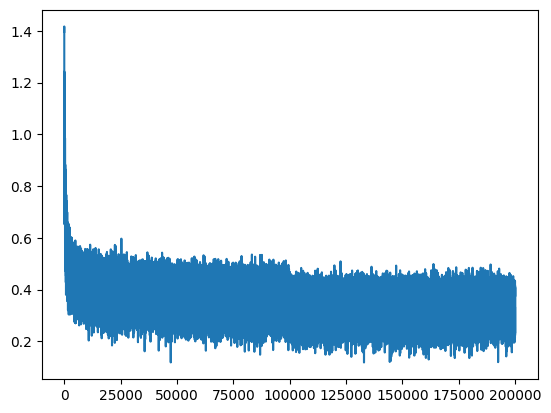

In [184]:
plt.plot(stepi, lossi)

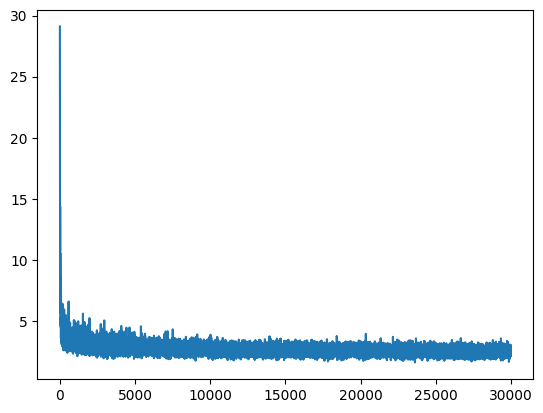

In [128]:
plt.plot(stepi, lossi)

In [185]:
# evaluate on the training set
emb = C[Xtr] # embedding of the input X
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # output of the first layer
logits = h @ W2 + b2 # output of the second layer (32, 27)
loss = F.cross_entropy(logits, Ytr) 
loss

tensor(2.1329, grad_fn=<NllLossBackward0>)

In [186]:
# evaluate on the dev set
emb = C[Xdev] # embedding of the input X
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # output of the first layer
logits = h @ W2 + b2 # output of the second layer (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1734, grad_fn=<NllLossBackward0>)

In [189]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) # random seed

for _ in range(10):
    out = []
    context = [0] * block_size # start with the context of length 3
    while True:
        emb = C[torch.tensor(context)] # embedding of the input X (1, block_size, 2)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2 # output of the second layer (1, 27)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample from the distribution
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

carpavela.
jhq.
khi.
mili.
taty.
skansh.
emmahnen.
delynn.
jareei.
nellara.


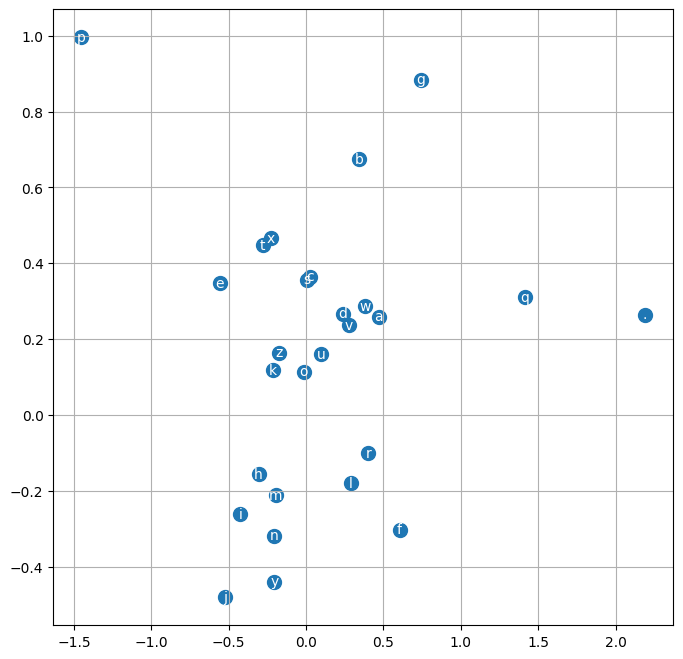

In [187]:
# bottleneck is the embedding layer, we can increase the size of the embedding layer, lets increase it to 30 from 2
# lets visualize the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=100)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# we are underfitting since the loss of training and validation is almost same, lets increase the capacity of the model

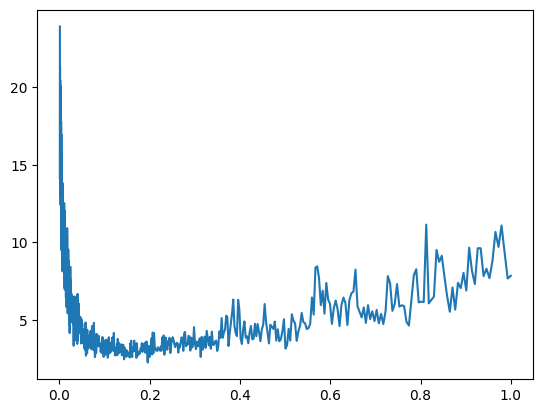

In [95]:
plt.plot(lri, lossi)

In [88]:
# we should optimize the above by using mini batches
torch.randint(0, X.shape[0], (32,))

tensor([116370,  21855, 207604,  13108, 146426, 206282,  93462, 101197,   5588,
         90166, 207574,  14253,  84419,  96395,  82889, 109448, 188387, 188440,
        178933,  39238,  66279, 159359, 225262, 219808,   8446,  71524,  62762,
         46633,  10546,  15220, 201046, 226620])

In [78]:
print(logits.max(dim=1)) # predictions
print(Y)               # targets

torch.return_types.max(
values=tensor([13.4138, 17.9644, 20.6772, 20.7267, 16.8571, 13.4138, 16.1147, 14.2718,
        16.0140, 18.5009, 16.0738, 21.0530, 13.4138, 17.2577, 17.2659, 20.2016,
        13.4138, 16.7053, 15.2578, 17.2021, 18.6942, 16.1057, 10.9961, 10.7943,
        15.5882, 13.4138, 16.2897, 17.0882, 12.8241, 16.2913, 19.2259, 16.1885],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))
tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


In [72]:
# following is why softmax and loss calaculation should not be done by us, because of numerical stability
logits = torch.tensor([-100, -3, 0, 100]) - 100 # internally pytorch will substract the max value from all logits, this is the way to handle large nums
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([0., 0., 0., nan])

In [ ]:
# training set, dev/validation set, test set
# train on training set, train hyperparameters on dev set, test on test set
# 80% train, 10% dev, 10% test